# Interactive Microscopy Control with ImJoy and MicroManager

Author: [Wei OUYANG](https://oeway.github.io/)

[ImJoy](https://imjoy.io) is a web framework for building interactive analysis tools. You can also use it to build easy-to-use and interactive data acquisition tool together with MicroManager.

In this tutorial notebook, we will go through the steps for using ImJoy plugins with MicroManager to control your microscope interactively. 

Here is a outline of this tutorial:
1. preparation
1. Acquire an image and display it with matplotlib
1. Acquire and display images continuously with matplotlib
1. Build your first ImJoy plugin
1. Snap an image in the ImJoy plugin
1. Visualize the image with the itk-vtk-viewer plugin
1. Use a dedicated UI plugin with MicroManager
1. Deploy your plugin to Github and share it
1. Additional Resources

## Preparation

Skip this step if you are running this notebook on Binder, the following preparation steps only concerns your local installation of MicroManager.

You will be able to follow this tutorial in a Jupyter notebook on the computer with Micro-Manager.

Importantly, MicroManager (the python binding) exposes full access of your microscope to the python scripting interface, please be careful that some commands (e.g. moving the stage) may damage your hardware. Although this tutorial only involves camera control which is safe, we still recommend to disconnect your hardware and start Micro-Manager with the simulated demo devices for exploration, and only connect the hardware when you fully understand the scripts.


1. Install Pymmcore, ImJoy and [ImJoy Jupyter Extension](https://github.com/imjoy-team/imjoy-jupyter-extension) by run `pip install pymmcore imjoy imjoy-jupyter-extension`, then start or restart your Jupyter notebook server by using `jupyter notebook` command.
2. When you open this Jupyter notebook, make sure you see an ImJoy icon in the toolbar in opened notebooks.
3. If you don't have Micro-Manager installed, download the lastest version of [micro-manager 2.0](https://micro-manager.org/wiki/Micro-Manager_Nightly_Builds)
4. Run Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once)



In [ ]:
# Skip this cell if you are running this notebook on Binder
!pip install pymmcore imjoy imjoy-jupyter-extension

## Set the path to your micromanager installation and config file

After installation, please set the path to your micromanager installation folder and a config file.

If you are running on Binder, you can keep the values as is.

In [2]:
import os

MM_DIR = "./mmcore"
MM_CONFIG_FILE = os.path.join(MM_DIR, "MMConfig_demo.cfg")

## Acquire an image and display it with matplotlib

By calling `core.snapImage()` we can control micromanager to acquire image and use `core.getImage()` to fetch the image data.

In a notebook, we can use matplotlib function `plt.imshow` to visualize the image.

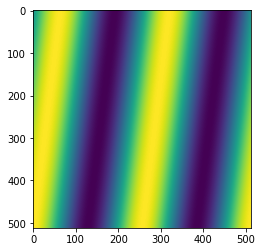

In [3]:
import numpy as np
from imjoy import api
import pymmcore
import os.path
from matplotlib import pyplot as plt
%matplotlib inline

mmc = pymmcore.CMMCore()
mmc.setDeviceAdapterSearchPaths([MM_DIR])
mmc.loadSystemConfiguration(MM_CONFIG_FILE)
mmc.snapImage()
image = mmc.getImage()
plt.imshow(image)

## Acquire and display images continuously
Since we are doing microscopy imaging with the microscope, it's important to be able to see a live stream, for example, for finding a field of view.

Jupyter notebook has little support for visualizing real-time data itself, but we can try to achieve live update by repeatitively clear the plot and draw again.

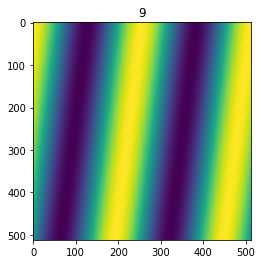

In [5]:
from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    plt.figure()
    plt.title(i)
    mmc.snapImage()
    image = mmc.getImage()
    plt.imshow(image)
    plt.show()

While we can see the live stream, it provides litte interactivity, for example, if we want to do contrast stretching, we will have to stop the stream and perhaps combine with some jupyter widgets to achieve it.

On the other hand, ImJoy is designed for providing this type of application. In the following section, you will see how we can achieve this by building an ImJoy plugin.

## Build your first ImJoy plugin

Let's start by making a "hello world" plugin example with ImJoy.

An ImJoy plugin is a class defines at least two functions `setup` and `run`. In the `setup` function we put preparation or initialization code and the `run` function is an entrypoint when the user starts the plugin. As an example, we do nothing in the `setup` function and popup a hello world message in the `run` function.

Importantly, you need to export your plugin by running `api.export(ImJoyPlugin())` to register the plugin to the ImJoy core (running in the browser with the notebook page).

Now run the following cell.

If you see a popup message saying "hello world", congrats that you have build your first ImJoy plugin!

In [7]:
from imjoy import api

class ImJoyPlugin():
    '''Defines an ImJoy plugin'''
    async def setup(self):
        '''for initialization'''
        pass

    async def run(self, ctx):
        '''called when the user run this plugin'''
        
        # show a popup message
        await api.alert("hello world")

# register the plugin to the imjoy core
api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

Note: if the `async` and `await` keywords are new to you, you may want to learn about an imporant programing style called "asynchronous programming". It's basically a cheap way to achieve parallelizatin in a single thread, and Python3 provides [asyncio API](https://docs.python.org/3/library/asyncio-task.html) for it. With the async/await syntax, you can write async code as you usually do with your other synchronous code.

Don't worry if you don't fully understand asynchronous programming. For now you can treat it the same as regular python programming, but remember the following simplified rules:
1. it is recommended to add `await` before every ImJoy api call except `api.export`, e.g.: do `await api.alert("hello")`.
2. if you used `await` in a function, then you have to also add `async def` to define the function.

## Snap an image in the ImJoy plugin

Now let's define a function for acquire images with Pycro-Manager and call it `snap_image()`. Add this function into the plugin class and use it in the `run` function.

Run the fullowing cell, you should see a message if you acquired an image.

In [12]:
import numpy as np
from imjoy import api

class MyMicroscope():
    '''Defines a Microscope plugin'''
    async def setup(self):
        '''initialize pymmcore '''
        mmc = pymmcore.CMMCore()
        mmc.setDeviceAdapterSearchPaths([MM_DIR])
        mmc.loadSystemConfiguration(MM_CONFIG_FILE)
        self.mmc = mmc
    
    def snap_image(self):
        '''snape an image with the micromanager bridge and return it as a numpy array'''
        self.mmc.snapImage()
        image_array = self.mmc.getImage()
        # for display, we can scale the image into the range of 0~255
        image_array = (image_array/image_array.max()*255).astype('uint8')
        return image_array

    async def run(self, ctx):
        '''acquire one image and notify the user'''
        img = self.snap_image()
        # show a popup message
        await api.alert("Acquired an image (size={}) with Micro-Manager".format(img.shape))

# register the plugin to the imjoy core
api.export(MyMicroscope())

<IPython.core.display.Javascript object>

## Visualize the image with the itk-vtk-viewer plugin

To show the images, we can use another ImJoy plugin called itk-vtk-viewer which provide rich featuers including color map, contrast stretching, scaling. It can be used directly via this link: https://oeway.github.io/itk-vtk-viewer/ as standalone web app, but also available as an ImJoy plugin.

To use it, you can run `viewer = await api.showDialog(src="https://oeway.github.io/itk-vtk-viewer/")` to create a viewer. The returned `viewer` object contains a set of API functions exported by the itk-vtk-viewer plugin, and we will call `viewer.imshow()` for displaying images where `imshow` is one of the API functions.

Note that we need to add `await` before `api.showDialog`, but also all the returned API functions including `imshow()`.

In the following plugin, we call `snape_image` and `viewer.imshow` in a for loop inside the `run` function, to continuously display the image.


In [20]:
import numpy as np
from imjoy import api
import pymmcore
import os.path

MM_DIR = "./mmcore"
MM_CONFIG_FILE = os.path.join(MM_DIR, "MMConfig_demo.cfg")

mmc = pymmcore.CMMCore()
mmc.setDeviceAdapterSearchPaths([MM_DIR])
mmc.loadSystemConfiguration(MM_CONFIG_FILE)
mmcore = mmc

class MyMicroscope():
    def setup(self):
        self._core = mmcore
        self._core.setExposure(float(10))
        exposure = self._core.getExposure()
        api.showMessage('MMcore loaded, exposure: ' + str(exposure))
    
    def snapImage(self):
        self._core.snapImage()
        image_array = self._core.getImage()
        image_array = (image_array/image_array.max()*255).astype('uint8')
        return image_array

    async def run(self, ctx):
        viewer = await api.showDialog(type="itk-vtk-viewer",
                                      src="https://oeway.github.io/itk-vtk-viewer/")
        api.showMessage('Acquiring 30 images')
        for i in range(30):
            await viewer.imshow(self.snapImage())
        api.showMessage('Done.')
        
api.export(MyMicroscope())

<IPython.core.display.Javascript object>

The itk-vtk-viewer plugin provides rich features for inspecting the displayed image, but it does not provide features to control the microscope.

## Use a dedicated UI plugin with Micro-Manager

ImJoy allows developers build custom plugins and can be easily used later in another plugin. For example, we can add buttons to snap image, provide options to change exposure in a custom UI plugin.

For working with Micro-Manager, we made a dedicated UI plugin called "PycroCam" which can be referred via https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd. If you are interested in how to make such a plugin, cick the link and you will see the plugin source code in HTML, Javascript and CSS.

For this tutorial, we will focuse on using such a plugin with Micro-Manager and it's as easy as calling `pycrocam = await api.createWindow(src="https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd", data={...})`.

Slightly different from the above example where we create a window via `api.createWindow` and we use the returned `viewer` object to access API functions such as `imshow`. In this example, we will directly pass a set of Micro-Manager core api functions to the `PycroCam` plugin so we can directly control the microscope within the plugin.

In the following `run` function, you will see that we first construct a dictionary (named `mmcore_api`) with a set of functions required by the plugin including `snapImage`, `getImage` and `setExposure`. Then we pass the dictionary into `api.createWindow()` as a keyword `data`, specifically, `data={'mmcore': mmcore_api}`. 


Run the following cell, and you will see the PycroCam UI with snap and live buttons, set exposure and binning. In addition you can click the "Device Properties" which will popup a device property browser. Just like the one in Micro-Manager itself, you can change almost any property with that.

In [ ]:
import time
from imjoy import api
import numpy as np
import pymmcore
import os.path

MM_DIR = "./mmcore"
MM_CONFIG_FILE = os.path.join(MM_DIR, "MMConfig_demo.cfg")


class MyMicroscope():
    async def setup(self):
        self.mmc = pymmcore.CMMCore()
        self.mmc.setDeviceAdapterSearchPaths([MM_DIR])
        self.mmc.loadSystemConfiguration(MM_CONFIG_FILE)

        exposure = self.mmc.getExposure()
        api.showMessage('MMcore loaded, exposure: ' + str(exposure))

    def snap_image(self):
        if self.mmc.isSequenceRunning():
            self.mmc.stopSequenceAcquisition()
        self.mmc.snapImage()
        image_array = self.mmc.getImage()
        image_array = (image_array/image_array.max()*255).astype('uint8')
        return image_array
    
    def get_image(self):
        # we can also check remaining with getRemainingImageCount()
        image_array = self.mmc.getImage()
        image_array = (image_array/image_array.max()*255).astype('uint8')
        return image_array

    def get_device_properties(self):
        devices = self.mmc.getLoadedDevices()
        device_items = []
        for device in devices:
            props = self.mmc.getDevicePropertyNames(device)
            property_items = []
            for prop in props:
                value = self.mmc.getProperty(device, prop)
                is_read_only = self.mmc.isPropertyReadOnly(device, prop)
                if self.mmc.hasPropertyLimits(device, prop):
                    lower = self.mmc.getPropertyLowerLimit(device, prop)
                    upper = self.mmc.getPropertyUpperLimit(device, prop)
                    allowed = {"type": "range", "min": lower, "max": upper, "readOnly": is_read_only}
                else:
                    allowed = self.mmc.getAllowedPropertyValues(device, prop)
                    allowed = {"type": "enum", "options": allowed, "readOnly": is_read_only}
                property_items.append({"device": device, "name": prop, "value": value, "allowed": allowed})
                # print('===>', device, prop, value, allowed)
            if len(property_items) > 0:
                device_items.append({"name": device, "value": "{} properties".format(len(props)), "items": property_items})
        return device_items

    async def run(self, ctx):
        mmcore_api = {
            "_rintf": True,
            "snapImage": self.snap_image,
            "getImage": self.get_image,
            "getDeviceProperties": self.get_device_properties,
            "getCameraDevice": self.mmc.getCameraDevice,
            "setCameraDevice": self.mmc.setCameraDevice,
            "startContinuousSequenceAcquisition": self.mmc.startContinuousSequenceAcquisition,
            "stopSequenceAcquisition": self.mmc.stopSequenceAcquisition,
            "setExposure": self.mmc.setExposure,
            "getExposure": self.mmc.getExposure,
            "setProperty": self.mmc.setProperty,
            "getProperty": self.mmc.getProperty
        }
        viewer = await api.createWindow(src="https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd", data={'mmcore': mmcore_api})

api.export(MyMicroscope())